In [18]:
%pylab inline

import theano
import theano.tensor.signal.downsample

from fuel.transformers import ScaleAndShift, Cast
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme, SequentialScheme

from blocks import *

import time

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [41]:
### Generic config

Config = {'batchsize-train' : 100,
          'batchsize-validation' : 100,
          'batchsize-test' : 100,
          'theano-debug' : False,
         }

theano.config.floatX = 'float32'
theano.config.compute_test_value = 'off'
if Config['theano-debug']:
    print "Set Theano to debug mode."
    theano.config.optimizer = 'fast_compile'
    theano.config.exception_verbosity = 'high'
else:
    theano.config.optimizer = 'fast_run'
    theano.config.exception_verbosity = 'low'


In [42]:
from fuel.datasets.cifar10 import CIFAR10

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'})
)

Data_Train      = CIFAR10(("train",), subset=slice(None ,45000))
Data_Validation = CIFAR10(("train",), subset=slice(45000, None))
Data_Test       = CIFAR10(("test" ,)                           )

Stream_Train     = DataStream.default_stream(
                      Data_Train,
                      iteration_scheme=ShuffledScheme(Data_Train.num_examples       , Config['batchsize-train'])
                   )
Stream_Validation = DataStream.default_stream(
                      Data_Validation,
                      iteration_scheme=SequentialScheme(Data_Validation.num_examples, Config['batchsize-validation'])
                   )
Stream_Test       = DataStream.default_stream(
                      Data_Test,
                      iteration_scheme=SequentialScheme(Data_Test.num_examples      , Config['batchsize-test'])
                   )

print "Loaded input data."
print "Subset sizes: Train %d, Validation %d, Test %d" % (Data_Train.num_examples, Data_Validation.num_examples, Data_Test.num_examples)

def GetNextBatch(stream):
    return next(stream.get_epoch_iterator())

print "Stream data shapes:"
x,y = GetNextBatch(Stream_Train)
print "Stream_Train: image batch of shape %s [%s], and label batch of shape %s [%s]" % (x.shape, x.dtype, y.shape, y.dtype)
x,y = GetNextBatch(Stream_Test)
print "Stream_Test: image batch of shape %s [%s], and label batch of shape %s [%s]" % (x.shape, x.dtype, y.shape, y.dtype)

Loaded input data.
Subset sizes: Train 45000, Validation 5000, Test 10000
Stream data shapes:
Stream_Train: image batch of shape (100, 3, 32, 32) [float32], and label batch of shape (100, 1) [uint8]
Stream_Test: image batch of shape (100, 3, 32, 32) [float32], and label batch of shape (100, 1) [uint8]


In [57]:

Input_X = theano.tensor.tensor4('X')
Input_Y = theano.tensor.matrix('Y', dtype='uint8')

num_filters_1 = 30 
num_filters_2 = 60 
num_fw3_hidden = 2000
num_fw4_hidden = 10



# Layer 1 - convolution 3 -> num_filters_1, filter 5x5, plus bias, then pooling 2x2
Param_1_Conv = theano.shared(np.zeros((num_filters_1,3,5,5), dtype='float32'), name='CW1')
Param_1_Conv.tag.initializer = IsotropicGaussian(0.05)
Param_1_Bias = theano.shared(np.zeros((num_filters_1,), dtype='float32'), name='CB1')
Param_1_Bias.tag.initializer = Constant(0.0)

# Layer 1 - convolution num_filters_2 -> num_filters_2, filter 5x5, plus bias, then pooling 2x2
Param_2_Conv = theano.shared(np.zeros((num_filters_2,num_filters_1,5,5), dtype='float32'), name='CW2')
Param_2_Conv.tag.initializer = IsotropicGaussian(0.05)
Param_2_Bias = theano.shared(np.zeros((num_filters_2,), dtype='float32'), name='CB2')
Param_2_Bias.tag.initializer = Constant(0.0)

# Layer 3 - fully connected, num_filters_2 * imagesize -> num_fw3_hidden, plus bias
Param_3_W = theano.shared(np.zeros((num_filters_2 * 5 * 5, num_fw3_hidden), dtype='float32'),name='FW3')
Param_3_W.tag.initializer = IsotropicGaussian(0.05)
Param_3_Bias = theano.shared(np.zeros((num_fw3_hidden,), dtype='float32'),name='FB3')
Param_3_Bias.tag.initializer = Constant(0.0)

# Layer 3 - fully connected, num_fw3_hidden -> num_fw4_hidden, plus bias
Param_4_W = theano.shared(np.zeros((num_fw3_hidden, num_fw4_hidden), dtype='float32'), name='FW4')
Param_4_W.tag.initializer = IsotropicGaussian(0.05)
Param_4_Bias = theano.shared(np.zeros((num_fw4_hidden,), dtype='float32'), name='FB4')
Param_4_Bias.tag.initializer = Constant(0.0)

        
ParamList  = []
ParamList += [Param_1_Conv, Param_1_Bias]
ParamList += [Param_2_Conv, Param_2_Bias]
ParamList += [Param_3_W   , Param_3_Bias]
ParamList += [Param_4_W   , Param_4_Bias]

# Network topology implementation
after_C1 = theano.tensor.maximum(    # ReLU
    0.0,
    theano.tensor.nnet.conv2d(Input_X, Param_1_Conv, filter_shape=(5,5)) + Param_1_Bias.dimshuffle('x',0,'x','x')
)

after_P1 = theano.tensor.signal.downsample.max_pool_2d(after_C1, (2,2), ignore_border=True)

after_C2 = theano.tensor.maximum(    # ReLU
    0.0,
    theano.tensor.nnet.conv2d(after_P1, Param_2_Conv) + Param_2_Bias.dimshuffle('x',0,'x','x')
)
after_P2 = theano.tensor.signal.downsample.max_pool_2d(after_C2, (2,2), ignore_border=True)

after_F3 = theano.tensor.maximum(    # ReLU
    0.0,
    theano.tensor.dot(after_P2.flatten(2), Param_3_W) + Param_3_Bias.dimshuffle('x',0)
)

after_F4 = theano.tensor.dot(after_F3, Param_4_W) + Param_4_Bias.dimshuffle('x',0)


Output_Probabilities = theano.tensor.nnet.softmax(after_F4)

Output_Predictions   = theano.tensor.argmax(Output_Probabilities, axis=1)

Output_ErrRate = theano.tensor.neq(Output_Predictions,Input_Y.ravel()).mean()
Output_NLL     = - theano.tensor.log(Output_Probabilities[theano.tensor.arange(Input_Y.shape[0]), Input_Y.ravel()]).mean()

Output_WeightDecay = 0.0
for p in ParamList:
    if p.name[1]=='W':
        Output_WeightDecay = Output_WeightDecay + 1e-3 * (p**2).sum()

Output_Cost = Output_NLL + Output_WeightDecay


In [58]:
# The updates will update our shared values
updates = []

Input_LRate    = theano.tensor.scalar('lrate',dtype='float32')
Input_Momentum = theano.tensor.scalar('momentum',dtype='float32')

# Theano will compute the gradients for us
Model_Gradients = theano.grad(Output_Cost, ParamList)

#initialize storage for momentum
Model_Velocities = [theano.shared(np.zeros_like(p.get_value()), name='V_%s' %(p.name, )) for p in ParamList]

for p,g,v in zip(ParamList, Model_Gradients, Model_Velocities):
    v_new = Input_Momentum * v - Input_LRate * g
    p_new = p + v_new
    updates += [(v,v_new), (p, p_new)]


In [59]:
#compile theano functions

#each call to train step will make one SGD step
Function_TrainStep = theano.function(
    [Input_X,Input_Y,Input_LRate,Input_Momentum],
    [Output_Cost, Output_ErrRate, Output_NLL, Output_WeightDecay],
    updates=updates,
    allow_input_downcast=True
)
#each call to predict will return predictions on a batch of data
Function_Predict = theano.function(
    [Input_X],
    Output_Predictions
)

In [60]:
rng = numpy.random.RandomState(1234)

def compute_error_rate(stream):
    errs = 0.0
    num_samples = 0.0
    for X, Y in stream.get_epoch_iterator():
        errs += (Function_Predict(X)!=Y.ravel()).sum()
        num_samples += Y.shape[0]
    return errs/num_samples

def init_parameters():
    global rng
    for p in ParamList:
        p.set_value(p.tag.initializer.generate(rng, p.get_value().shape))

def snapshot_parameters():
    return [p.get_value(borrow=False) for p in ParamList]

def load_parameters(snapshot):
    for p, s in zip(ParamList, snapshot):
        p.set_value(s, borrow=False)

In [61]:
i=0
e=0

init_parameters()
for v in Model_Velocities:
    v.set_value(np.zeros_like(v.get_value()))

Training_Best_ErrRate = np.inf
Training_Best_Params = snapshot_parameters()
Training_Best_Epoch = 0

train_erros = []
train_loss = []
train_nll = []
validation_errors = []

number_of_epochs = 3
patience_expansion = 1.5
# training loop

Training_StartTime = time.time()

while e<number_of_epochs: #This loop goes over epochs
    e += 1
    #First train on all data from this batch
    epoch_start_i = i
    
    epoch_starttime = time.time()
    for X_batch, Y_batch in Stream_Train.get_epoch_iterator(): 
        i += 1
        
        K = 2000
        lrate = 4e-3 * K / np.maximum(K, i)
        momentum=0.9
        
        # momentum = 1.0 - np.maximum(np.minimum(200.0/(i+1), 0.4), 0.01)
        momentum=0.97
        
        L, err_rate, nll, wdec = Function_TrainStep(X_batch, Y_batch, lrate, momentum)
        
        train_loss.append((i,L))
        train_erros.append((i,err_rate))
        train_nll.append((i,nll))
        if i % 100 == 0:
            print "At minibatch %d, batch loss %f, batch nll %f, batch error rate %f%%" % (i, L, nll, err_rate*100)
        
    epoch_endtime = time.time()
    print "Time per epoch: %ss" % (epoch_endtime - epoch_starttime)
    # After an epoch compute validation error
    val_error_rate = compute_error_rate(Stream_Validation)
    if val_error_rate < Training_Best_ErrRate:
        number_of_epochs = np.maximum(number_of_epochs, e * patience_expansion+1)
        Training_Best_ErrRate = val_error_rate
        Training_Best_Params = snapshot_parameters()
        Training_Best_Epoch = e
    validation_errors.append((i,val_error_rate))
    print "After epoch %d: valid_err_rate: %f%% currently going to do %d epochs" %(
        e, val_error_rate*100, number_of_epochs)
    print "After epoch %d: averaged train_err_rate: %f%% averaged train nll: %f averaged train loss: %f" %(
        e, np.mean(np.asarray(train_erros)[epoch_start_i:,1])*100, 
        np.mean(np.asarray(train_nll)[epoch_start_i:,1]),
        np.mean(np.asarray(train_loss)[epoch_start_i:,1]))

Training_EndTime = time.time()
print "TOTAL TIME: %ss" % int(Training_EndTime - Training_StartTime)

At minibatch 100, batch loss 8.951997, batch nll 1.536584, batch error rate 50.000000%
At minibatch 200, batch loss 8.371844, batch nll 1.330837, batch error rate 46.000000%
At minibatch 300, batch loss 8.135177, batch nll 1.455779, batch error rate 50.000000%
At minibatch 400, batch loss 7.641599, batch nll 1.305217, batch error rate 49.000000%
Time per epoch: 16.4476411343s
After epoch 1: valid_err_rate: 43.520000% currently going to do 3 epochs
After epoch 1: averaged train_err_rate: 54.702222% averaged train nll: 1.522259 averaged train loss: 8.475458
At minibatch 500, batch loss 7.180609, batch nll 1.167450, batch error rate 44.000000%
At minibatch 600, batch loss 7.043988, batch nll 1.335720, batch error rate 53.000000%
At minibatch 700, batch loss 6.630662, batch nll 1.212371, batch error rate 42.000000%
At minibatch 800, batch loss 6.104923, batch nll 0.961358, batch error rate 41.000000%
At minibatch 900, batch loss 5.981856, batch nll 1.098143, batch error rate 34.000000%
Tim

Setting network parameters from after epoch 1
Test error rate is 25.970000%


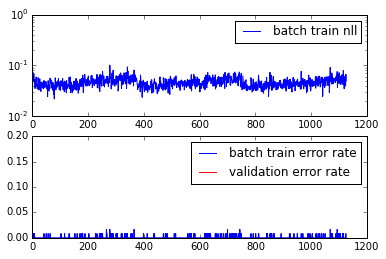

In [38]:
print "Setting network parameters from after epoch %d" %(Training_Best_Epoch)
load_parameters(Training_Best_Params)

print "Test error rate is %f%%" %(compute_error_rate(Stream_Test)*100.0,)

subplot(2,1,1)
train_nll_a = np.array(train_nll)
semilogy(train_nll_a[:,0], train_nll_a[:,1], label='batch train nll')
legend()

subplot(2,1,2)
train_erros_a = np.array(train_erros)
plot(train_erros_a[:,0], train_erros_a[:,1], label='batch train error rate')
validation_errors_a = np.array(validation_errors)
plot(validation_errors_a[:,0], validation_errors_a[:,1], label='validation error rate', color='r')
ylim(0,0.2)
legend()